### Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

# modeling & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, precision_recall_fscore_support, accuracy_score
import xgboost as xgb
import shap

# helper
import joblib

RANDOM_STATE = 42

c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

In [2]:
path = r"C:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\data\raw\MachineLearningRating_v3.txt"
df = pd.read_csv(path, sep='|', dtype=str, low_memory=False)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11372\1862972542.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929824561403,.000000000000
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929824561403,.000000000000
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,.000000000000,.000000000000
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070175439,.000000000000
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,.000000000000,.000000000000


### Basic cleaning & type conversions

In [3]:
# parse TransactionMonth
if 'TransactionMonth' in df.columns:
    df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# numeric columns
num_cols_guess = ['RegistrationYear','Cylinders','cubiccapacity','kilowatts',
                  'NumberOfDoors','CustomValueEstimate','CapitalOutstanding',
                  'NumberOfVehiclesInFleet','SumInsured','CalculatedPremiumPerTerm',
                  'ExcessSelected','TotalPremium','TotalClaims']

for c in num_cols_guess:
    if c in df.columns:
        col = df[c]
        if not pd.api.types.is_numeric_dtype(col):
            col = col.astype(str).str.replace(',', '', regex=False)
            col = col.replace(['', ' ', 'nan', 'None', 'NoneType'], np.nan)
        df[c] = pd.to_numeric(col, errors='coerce')

# create has_claim flag
df['has_claim'] = (df.get('TotalClaims', 0).fillna(0) > 0).astype(int)


### Feature engineering

In [4]:
# vehicle_age
if 'RegistrationYear' in df.columns and 'TransactionMonth' in df.columns:
    df['vehicle_age'] = df['TransactionMonth'].dt.year - df['RegistrationYear']
    df['vehicle_age'] = df['vehicle_age'].where(df['vehicle_age'] >= 0, np.nan)

# premium_to_suminsured
if 'CalculatedPremiumPerTerm' in df.columns and 'SumInsured' in df.columns:
    df['premium_to_suminsured'] = df['CalculatedPremiumPerTerm'] / df['SumInsured']
    df['premium_to_suminsured'].replace([np.inf, -np.inf], np.nan, inplace=True)

# log transform of TotalClaims
if 'TotalClaims' in df.columns:
    df['log_totalclaims'] = np.where(df['TotalClaims'] > 0, np.log1p(df['TotalClaims']), np.nan)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11372\129209658.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['premium_to_suminsured'].replace([np.inf, -np.inf], np.nan, inplace=True)
c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# simple aggregation: historical claims per PolicyID
if 'PolicyID' in df.columns and 'TotalClaims' in df.columns:
    hist = df.groupby('PolicyID').agg(
        policy_claim_count=('has_claim', 'sum'),
        policy_mean_claim=('TotalClaims', lambda x: np.nansum(x.fillna(0)) / (x.count() if x.count()>0 else 1))
    ).reset_index()
    df = df.merge(hist, on='PolicyID', how='left')


### Feature selection

In [6]:
candidate_features = [
    'vehicle_age','make','Model','VehicleType','Cylinders','cubiccapacity','kilowatts',
    'bodytype','NumberOfDoors','CustomValueEstimate','AlarmImmobiliser','TrackingDevice',
    'CapitalOutstanding','NumberOfVehiclesInFleet','SumInsured','CalculatedPremiumPerTerm',
    'premium_to_suminsured','AccountType','Product','CoverType','Country','Province',
    'policy_claim_count','policy_mean_claim'
]
features = [f for f in candidate_features if f in df.columns]


### Regression: Claim Severity

In [7]:
df_claims = df[df['TotalClaims'] > 0].copy()
df_claims = df_claims[~df_claims['log_totalclaims'].isnull()].copy()

X = df_claims[features].copy()
y = df_claims['log_totalclaims'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)


In [8]:
# Identify numeric vs categorical
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

# Preprocessing pipelines (memory-efficient)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))  # sparse to save memory
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
], sparse_threshold=0.0)


In [9]:
# Linear Regression
pipe_lr = Pipeline([('pre', preprocessor), ('model', LinearRegression())])
pipe_lr.fit(X_train, y_train)

# Random Forest
pipe_rf = Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1))])
pipe_rf.fit(X_train, y_train)

# XGBoost
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=4, learning_rate=0.1, random_state=RANDOM_STATE, n_jobs=-1)
pipe_xgb = Pipeline([('pre', preprocessor), ('model', xgb_reg)])
pipe_xgb.fit(X_train, y_train)


c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.w

,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
# Evaluation helper
def eval_regression(pipe, X_test, y_test_log):
    y_pred_log = pipe.predict(X_test)
    y_true = np.expm1(y_test_log)
    y_pred = np.expm1(y_pred_log)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

models = {'Linear': pipe_lr, 'RandomForest': pipe_rf, 'XGBoost': pipe_xgb}
for name, m in models.items():
    res = eval_regression(m, X_test, y_test)
    print(f"{name} -> RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}, R2: {res['r2']:.4f}")


c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Linear -> RMSE: 31266.9858, MAE: 13362.1288, R2: 0.3410
RandomForest -> RMSE: 30328.1252, MAE: 12118.1726, R2: 0.3800
XGBoost -> RMSE: 29790.0619, MAE: 12092.3166, R2: 0.4018


c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


### Classification: Predict claim occurrence

In [11]:
X_cls = df[features].copy()
y_cls = df['has_claim'].copy()
mask_valid = X_cls.dropna(how='all').index
X_cls = X_cls.loc[mask_valid]
y_cls = y_cls.loc[mask_valid]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cls, y_cls, test_size=0.25, random_state=RANDOM_STATE, stratify=y_cls)


In [12]:
# Compute scale_pos_weight for imbalance
neg = sum(yc_train == 0)
pos = sum(yc_train == 1)
scale_pos_weight = neg / pos

In [13]:
# Preprocess once
Xc_train_trans = preprocessor.fit_transform(Xc_train)
Xc_test_trans = preprocessor.transform(Xc_test)

c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [14]:
# Train XGBoost (faster, smaller trees)
clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    max_depth=4,
    n_estimators=100,
    learning_rate=0.1
)
clf.fit(Xc_train_trans, yc_train)

c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:35:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [15]:
# Predictions
y_prob = clf.predict_proba(Xc_test_trans)[:, 1]
threshold = 0.1
y_pred = (y_prob >= threshold).astype(int)

In [16]:
# Metrics
auc = roc_auc_score(yc_test, y_prob)
precision, recall, f1, _ = precision_recall_fscore_support(yc_test, y_pred, average='binary', zero_division=0)
acc = accuracy_score(yc_test, y_pred)
print('\nClassification metrics:')
print(f'AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}')



Classification metrics:
AUC: 0.9707, Precision: 0.0205, Recall: 0.9943, F1: 0.0401, Accuracy: 0.8675


### SHAP explainability

c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


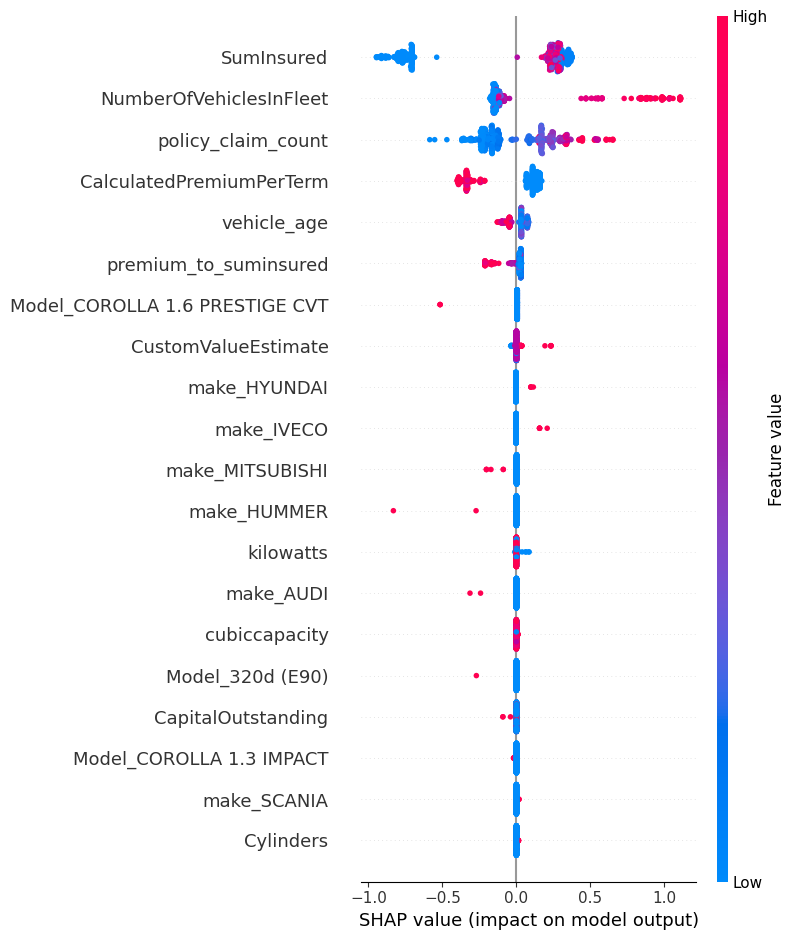

c:\Users\Administrator\Downloads\week-3\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['NumberOfVehiclesInFleet']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
100%|===================| 250023/250025 [08:32<00:00]        

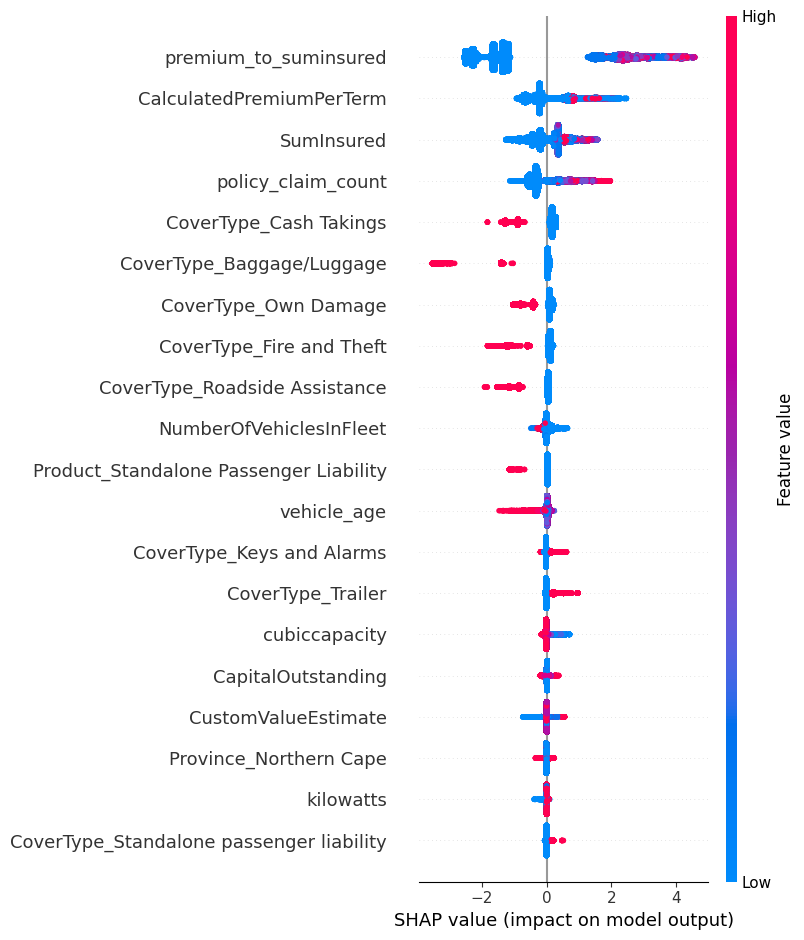

In [19]:

# Helper function to get feature names after preprocessing
def get_feature_names(preprocessor):
    # numeric features
    num_features = preprocessor.transformers_[0][2]
    
    # categorical features
    cat_pipeline = preprocessor.transformers_[1][1]
    cat_features = cat_pipeline.named_steps['onehot'].get_feature_names_out(preprocessor.transformers_[1][2])
    
    # combine
    return np.concatenate([num_features, cat_features])

# Get transformed feature names
feature_names_trans = get_feature_names(pipe_xgb['pre'])

# --------------------------
# Regression SHAP
# --------------------------
X_test_trans = pipe_xgb['pre'].transform(X_test)
explainer_reg = shap.Explainer(pipe_xgb['model'], X_test_trans)
shap_values_reg = explainer_reg(X_test_trans)

# Summary plot
shap.summary_plot(
    shap_values_reg,
    features=X_test_trans,
    feature_names=feature_names_trans
)

# --------------------------
# Classification SHAP
# --------------------------
Xc_test_trans = preprocessor.transform(Xc_test)
feature_names_cls = get_feature_names(preprocessor)

explainer_cls = shap.Explainer(clf, Xc_test_trans)
shap_values_cls = explainer_cls(Xc_test_trans)

# Summary plot
shap.summary_plot(
    shap_values_cls,
    features=Xc_test_trans,
    feature_names=feature_names_cls
)


### Top SHAP Features for Regression

In [20]:
# Mean absolute SHAP values
shap_vals_mean = np.abs(shap_values_reg.values).mean(axis=0)

# Get indices of top 10 features
top_idx = np.argsort(shap_vals_mean)[-10:][::-1]
top_features = feature_names_trans[top_idx]
print("Top 10 influential features for claim severity (regression):")
for f, val in zip(top_features, shap_vals_mean[top_idx]):
    print(f"{f}: mean(|SHAP|) = {val:.4f}")

# Business interpretation example
print("\nBusiness interpretation (example):")
print("For example, higher 'vehicle_age' increases predicted claim severity,")
print("indicating older vehicles are more likely to incur higher claim costs.")

# ----------------------------
# 2. Top SHAP Features for Classification
# ----------------------------
shap_vals_cls_mean = np.abs(shap_values_cls.values).mean(axis=0)
top_idx_cls = np.argsort(shap_vals_cls_mean)[-10:][::-1]
top_features_cls = feature_names_cls[top_idx_cls]
print("\nTop 10 influential features for claim occurrence (classification):")
for f, val in zip(top_features_cls, shap_vals_cls_mean[top_idx_cls]):
    print(f"{f}: mean(|SHAP|) = {val:.4f}")

print("\nBusiness interpretation (example):")
print("Features like 'policy_claim_count' and 'vehicle_age' increase probability of a claim," 
      "helping refine risk-based premiums for high-risk policies.")


Top 10 influential features for claim severity (regression):
SumInsured: mean(|SHAP|) = 0.4303
NumberOfVehiclesInFleet: mean(|SHAP|) = 0.2493
policy_claim_count: mean(|SHAP|) = 0.2161
CalculatedPremiumPerTerm: mean(|SHAP|) = 0.1881
vehicle_age: mean(|SHAP|) = 0.0513
premium_to_suminsured: mean(|SHAP|) = 0.0412
Model_COROLLA 1.6 PRESTIGE CVT: mean(|SHAP|) = 0.0074
CustomValueEstimate: mean(|SHAP|) = 0.0054
make_HYUNDAI: mean(|SHAP|) = 0.0037
make_IVECO: mean(|SHAP|) = 0.0033

Business interpretation (example):
For example, higher 'vehicle_age' increases predicted claim severity,
indicating older vehicles are more likely to incur higher claim costs.

Top 10 influential features for claim occurrence (classification):
premium_to_suminsured: mean(|SHAP|) = 2.0440
CalculatedPremiumPerTerm: mean(|SHAP|) = 0.5711
SumInsured: mean(|SHAP|) = 0.4770
policy_claim_count: mean(|SHAP|) = 0.4725
CoverType_Cash Takings: mean(|SHAP|) = 0.2674
CoverType_Baggage/Luggage: mean(|SHAP|) = 0.1777
CoverType_Ow

### Correct SHAP Bar Summary (Regression)


Regression SHAP Summary Plot (Bar):


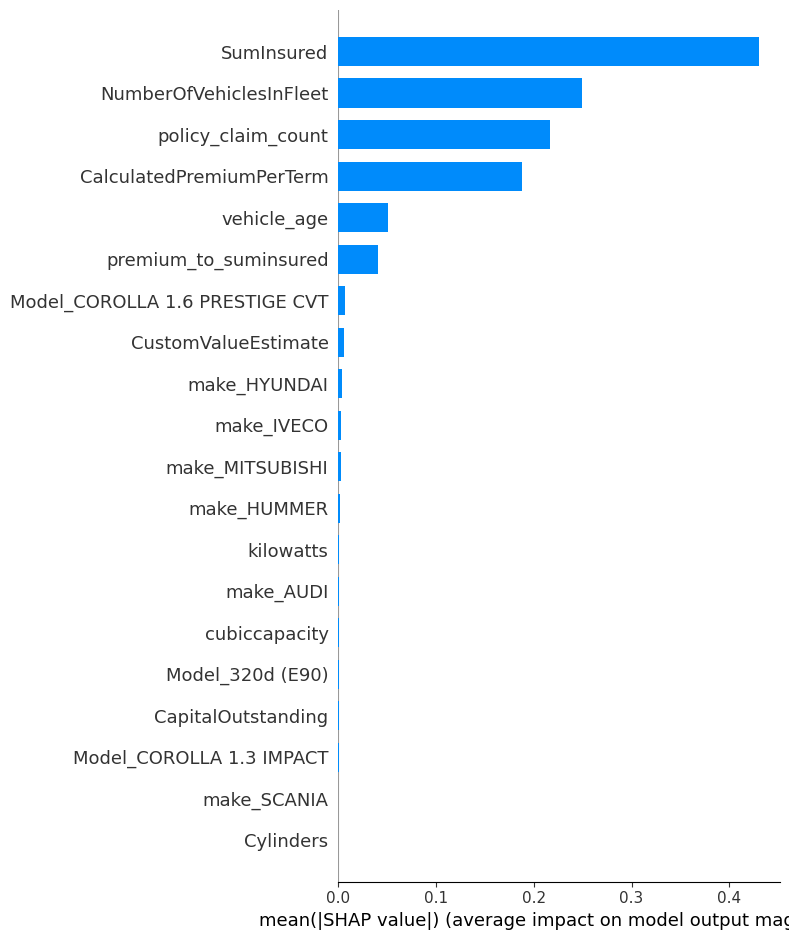

In [23]:
print("\nRegression SHAP Summary Plot (Bar):")
shap.summary_plot(
    shap_values_reg.values,
    features=X_test_trans,
    feature_names=feature_names_trans,
    plot_type="bar"
)


### Correct SHAP Bar Summary (Classification)


Classification SHAP Summary Plot (Bar):


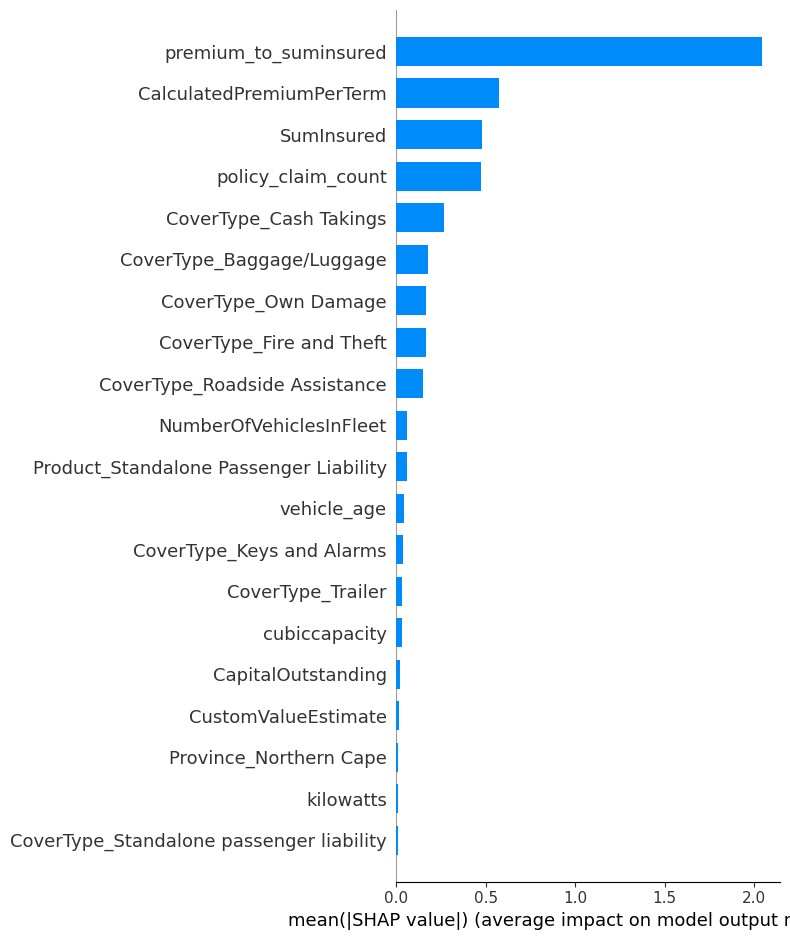

In [24]:
print("\nClassification SHAP Summary Plot (Bar):")
shap.summary_plot(
    shap_values_cls.values,
    features=Xc_test_trans,
    feature_names=feature_names_cls,
    plot_type="bar"
)
